In [ ]:
from copy import copy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
N = 30
q = 1
T = 5000

b = 80
C = 1
D = C*np.sqrt(b)
L = C*b
G = C*np.sqrt(b**3)

alphas = [(C*b)/np.sqrt(np.sum([((4*np.pi**2)**k)*((j/2)**(2*k)) for k in range(3)])) for j in range(2*N + 1)]
D_2m = sum(4*alphas)

alpha = np.sqrt(2/(T*(G**2)*(D**2)))
M = int(np.ceil(0.5*np.log2(1 + 4*T/7)) + 1)
eta = (((2**np.arange(0,M))*D)/G)*np.sqrt(7)/np.sqrt(2*T)

In [ ]:
def join_arrs(a0, arr1, arr2):
    new_arr = np.zeros(len(arr1) + len(arr2))
    new_arr[::2] = arr1
    new_arr[1::2] = arr2
    new_arr = np.concatenate(([a0], new_arr))
    return new_arr

def solve_euler(h, q):
    t = symbols('t')
    x = Function('x')
    C1 = symbols('C1')
    C2 = symbols('C2')
    x = dsolve(- diff(x(t), t, t) + q**2*x(t) - h , x(t)).rhs
    cond1 = x.subs(t, 0) - x.subs(t, 1)
    cond2 = diff(x, t).subs(t, 0) - diff(x, t).subs(t, 1)
    solution = solve([cond1, cond2], [C1, C2])
    x = x.subs(C1, solution[C1]).subs(C2, solution[C2])
    return x

def pop_fourier_coefs(func):
    a0 =  np.trapezoid(func(np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
    an = np.zeros(N)
    bn = np.zeros(N)

    for n in range(1, N+1):
        an[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.cos(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
        bn[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.sin(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))

    return a0, an, bn

def fourier_series(t, a0, an, bn, N):
    return a0 + np.sum([an[n] * np.sqrt(2)*np.cos((n+1) * 2*np.pi * t) + bn[n] * np.sqrt(2)*np.sin((n+1) * 2*np.pi * t) for n in range(N)])


## $\psi$ = 1.5

In [ ]:
p = np.zeros((T, M))
p[0] =(M+1)/M * (1/(np.arange(1, M+1))/(np.arange(2, M+2)))

np.random.seed(0)
w_experts = np.zeros((T, M, 2*N+1))
w_experts[0] = np.random.random((M, 2*N+1))

w = np.zeros((T, 2*N+1))
w[0] = np.sum(p[0].reshape(-1, 1)*w_experts[0], axis = 0)

Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = 1.5
t = symbols('t')

h_sp = 10*pi**2*cos(2*psi*pi*t)
h = lambdify(t, h_sp)

x_sp = solve_euler(h_sp, q)
x = lambdify(t, x_sp)

a0, an, bn = pop_fourier_coefs(x)
h_a0, h_an, h_bn = pop_fourier_coefs(h)

x_hat = join_arrs(a0, an, bn)
h_hat = join_arrs(h_a0, h_an, h_bn)

def grad_J(w, j):
    return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

def gradient(w):
    return np.array([grad_J(w, j) for j in range(2*N+1)])

def J_n(w):
    return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)]))- np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])
for i in range(T-1):


    gradient_w = gradient(w[i])
    loss = np.zeros(M)
    for j in range(M):
        w_experts[i+1][j] = np.clip(w_experts[i][j] - eta[j]*gradient_w, -np.sqrt(alphas), np.sqrt(alphas))
        loss[j] = gradient_w.dot(w_experts[i][j] - w[i])
    p[i+1] = np.exp(-alpha*loss)/np.sum(np.exp(-alpha*loss))
    w[i+1] = np.sum(p[i+1].reshape(-1, 1)*w_experts[i+1], axis = 0)
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

7.57834354594422e-5

In [ ]:
Regret_J_n[-1]

0.211162763859050

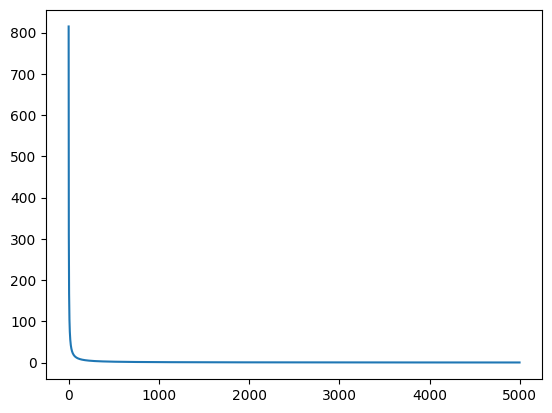

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = N(0, 0.03)

In [ ]:
# Initialize probability distribution over experts
p = np.zeros((T, M))
p[0] = (M+1)/M * (1/(np.arange(1, M+1))/(np.arange(2, M+2)))

# Set random seed for reproducibility
np.random.seed(0)

# Initialize experts' weights and aggregate weights
w_experts = np.zeros((T, M, 2*N+1))
w_experts[0] = np.random.random((M, 2*N+1))

w = np.zeros((T, 2*N+1))
w[0] = np.sum(p[0].reshape(-1, 1)*w_experts[0], axis=0)  # Initial weighted combination

# Initialize performance tracking lists
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.random.normal(0, 0.03, T)  # Psi values for every time step
t = symbols('t')

# Main optimization loop
for i in range(T-1):
    # Create symbolic functions for dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve Euler-Lagrange equation
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient and objective functions
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)]))- np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Compute gradient and update experts
    gradient_w = gradient(w[i])
    loss = np.zeros(M)
    for j in range(M):
        # Update expert with gradient step and projection
        w_experts[i+1][j] = np.clip(w_experts[i][j] - eta[j]*gradient_w, -np.sqrt(alphas), np.sqrt(alphas))
        loss[j] = gradient_w.dot(w_experts[i][j] - w[i])

    # Update expert probabilities using exponential weights
    p[i+1] = np.exp(-alpha*loss)/np.sum(np.exp(-alpha*loss))

    # Update aggregate weights
    w[i+1] = np.sum(p[i+1].reshape(-1, 1)*w_experts[i+1], axis=0)

    # Track performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

171.591447725903

In [ ]:
Regret_J_n[-1]

169.589026771394

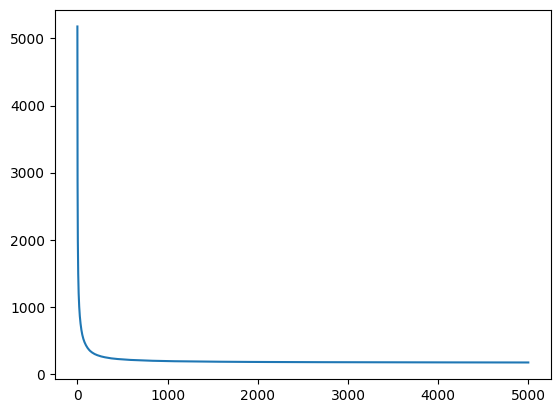

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
# Initialize probability distribution over experts
p = np.zeros((T, M))
p[0] = (M+1)/M * (1/(np.arange(1, M+1))/(np.arange(2, M+2)))

# Set random seed for reproducibility
np.random.seed(0)

# Initialize experts' weights and aggregate weights
w_experts = np.zeros((T, M, 2*N+1))
w_experts[0] = np.random.random((M, 2*N+1))

w = np.zeros((T, 2*N+1))
w[0] = np.sum(p[0].reshape(-1, 1)*w_experts[0], axis=0)  # Initial weighted combination

# Initialize performance tracking lists
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.linspace(2, 3, T)  # Psi values for every time step
t = symbols('t')

# Main optimization loop
for i in range(T-1):
    # Create symbolic functions for dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve Euler-Lagrange equation
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient and objective functions
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)]))- np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Compute gradient and update experts
    gradient_w = gradient(w[i])
    loss = np.zeros(M)
    for j in range(M):
        # Update expert with gradient step and projection
        w_experts[i+1][j] = np.clip(w_experts[i][j] - eta[j]*gradient_w, -np.sqrt(alphas), np.sqrt(alphas))
        loss[j] = gradient_w.dot(w_experts[i][j] - w[i])

    # Update expert probabilities using exponential weights
    p[i+1] = np.exp(-alpha*loss)/np.sum(np.exp(-alpha*loss))

    # Update aggregate weights
    w[i+1] = np.sum(p[i+1].reshape(-1, 1)*w_experts[i+1], axis=0)

    # Track performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

0.000142994375588401

In [ ]:
Regret_J_n[-1]

0.197848183273382

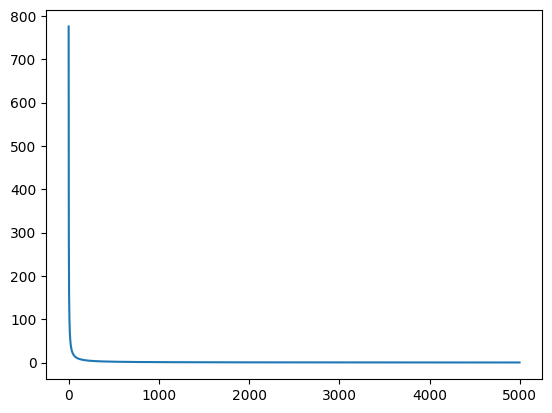

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = [0.5]*int(T/2) + [1.5]*int(T/2)

In [ ]:
# Initialize probability distribution over experts
p = np.zeros((T, M))
p[0] = (M+1)/M * (1/(np.arange(1, M+1))/(np.arange(2, M+2)))

# Set random seed for reproducibility
np.random.seed(0)

# Initialize experts' weights and aggregate weights
w_experts = np.zeros((T, M, 2*N+1))
w_experts[0] = np.random.random((M, 2*N+1))

w = np.zeros((T, 2*N+1))
w[0] = np.sum(p[0].reshape(-1, 1)*w_experts[0], axis=0)  # Initial weighted combination

# Initialize performance tracking lists
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi =  [0.5]*int(T/2) + [1.5]*int(T/2)  # Psi values for every time step
t = symbols('t')

# Main optimization loop
for i in range(T-1):
    # Create symbolic functions for dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve Euler-Lagrange equation
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient and objective functions
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)]))- np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Compute gradient and update experts
    gradient_w = gradient(w[i])
    loss = np.zeros(M)
    for j in range(M):
        # Update expert with gradient step and projection
        w_experts[i+1][j] = np.clip(w_experts[i][j] - eta[j]*gradient_w, -np.sqrt(alphas), np.sqrt(alphas))
        loss[j] = gradient_w.dot(w_experts[i][j] - w[i])

    # Update expert probabilities using exponential weights
    p[i+1] = np.exp(-alpha*loss)/np.sum(np.exp(-alpha*loss))

    # Update aggregate weights
    w[i+1] = np.sum(p[i+1].reshape(-1, 1)*w_experts[i+1], axis=0)

    # Track performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

7.57834354594422e-5

In [ ]:
Regret_J_n[-1]

0.240181597975428

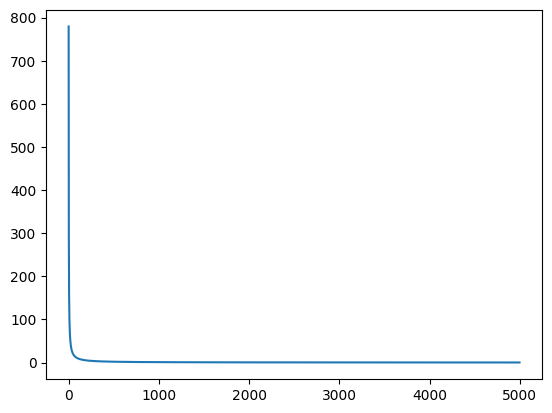

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
# Initialize probability distribution over experts
p = np.zeros((T, M))
p[0] = (M+1)/M * (1/(np.arange(1, M+1))/(np.arange(2, M+2)))

# Set random seed for reproducibility
np.random.seed(0)

# Initialize experts' weights and aggregate weights
w_experts = np.zeros((T, M, 2*N+1))
w_experts[0] = np.random.random((M, 2*N+1))

w = np.zeros((T, 2*N+1))
w[0] = np.sum(p[0].reshape(-1, 1)*w_experts[0], axis=0)  # Initial weighted combination

# Initialize performance tracking lists
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi =  np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)  # Psi values for every time step
t = symbols('t')

# Main optimization loop
for i in range(T-1):
    # Create symbolic functions for dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve Euler-Lagrange equation
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient and objective functions
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)]))- np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Compute gradient and update experts
    gradient_w = gradient(w[i])
    loss = np.zeros(M)
    for j in range(M):
        # Update expert with gradient step and projection
        w_experts[i+1][j] = np.clip(w_experts[i][j] - eta[j]*gradient_w, -np.sqrt(alphas), np.sqrt(alphas))
        loss[j] = gradient_w.dot(w_experts[i][j] - w[i])

    # Update expert probabilities using exponential weights
    p[i+1] = np.exp(-alpha*loss)/np.sum(np.exp(-alpha*loss))

    # Update aggregate weights
    w[i+1] = np.sum(p[i+1].reshape(-1, 1)*w_experts[i+1], axis=0)

    # Track performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

0.189888093371338

In [ ]:
Regret_J_n[-1]

1.22870062725308

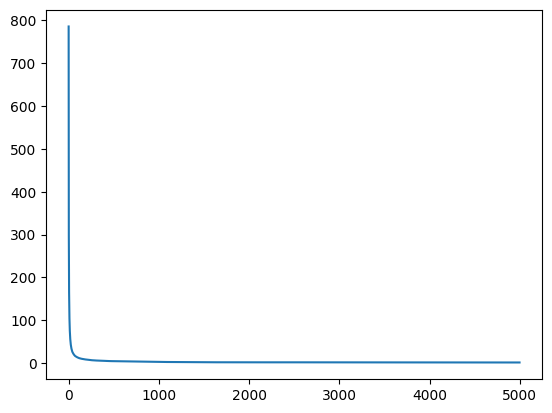

In [ ]:
plt.plot(Regret_J_n)